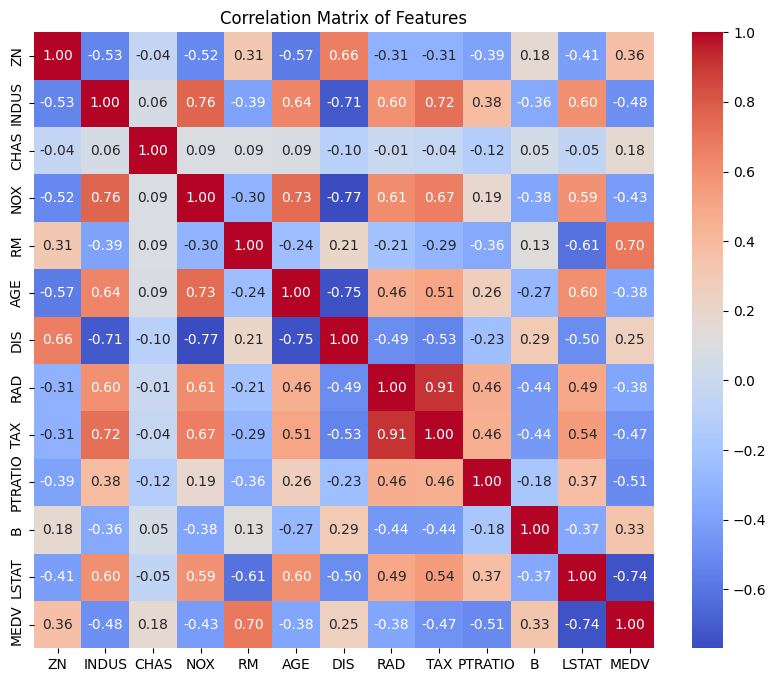

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Cross-validation MSE: 43.4411781164577
MSE: 14.369942029676919
R2: 0.7392034244209407
MAE: 1.5565469581501108
MAPE: 1.509636601796116
RMSE: 3.790770637967552
    Actual  Predicted     Error
0  0.00632   0.240563 -0.234243
1  0.02731   0.107295 -0.079985
2  0.02729   0.136756 -0.109466
3  0.03237   0.042033 -0.009663
4  0.06905   0.046726  0.022324


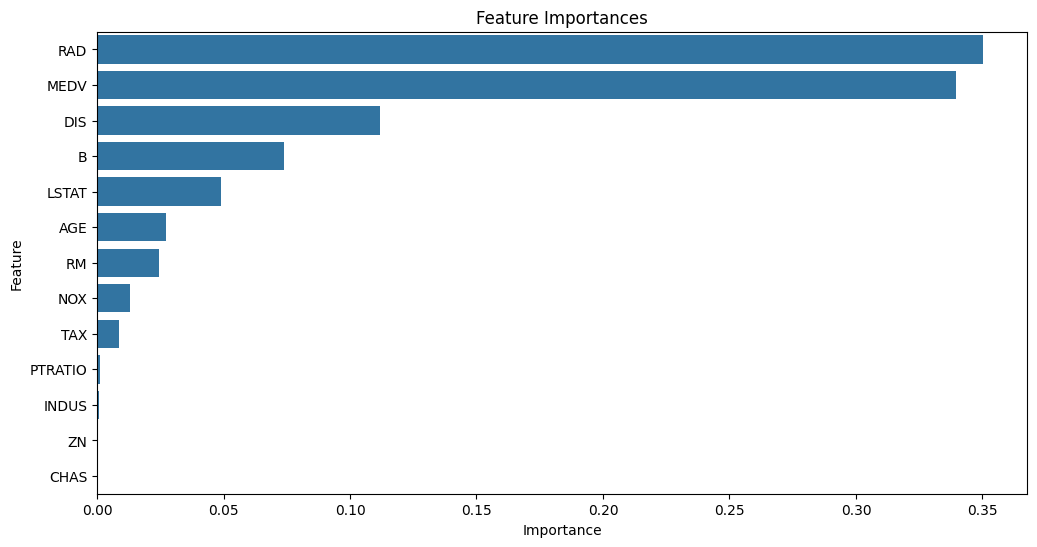

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.feature_selection import SelectFromModel

# CSVファイルの読み込み
file_path = 'C:/Users/thisi/OneDrive/デスクトップ/Dateset1.csv'  # 適切なファイルパスに変更してください
df = pd.read_csv(file_path)

# 目的変数と説明変数の指定
target_variable = 'CRIM'  # 目的変数のカラム名に変更してください
X = df.drop(columns=[target_variable])
y = df[target_variable]

# 説明変数間の相関関係を示す画像の出力
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ランダムフォレストのモデル定義
rf = RandomForestRegressor(random_state=42)

# ハイパーパラメータの設定とGridSearchCVによるチューニング
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# 最適なハイパーパラメータ
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# 最適なハイパーパラメータでモデルを再定義
best_rf = grid_search.best_estimator_

# k分割交差検定
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(best_rf, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
print(f"Cross-validation MSE: {-cv_results.mean()}")

# 特徴量選択（省略可能）
selector = SelectFromModel(best_rf, threshold='mean')
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# モデルの学習
best_rf.fit(X_train, y_train)

# 予測
y_pred_train = best_rf.predict(X_train)
y_pred_test = best_rf.predict(X_test)

# 評価指標の計算
mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
mape = mean_absolute_percentage_error(y_test, y_pred_test)
rmse = np.sqrt(mse)

print(f"MSE: {mse}")
print(f"R2: {r2}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"RMSE: {rmse}")

# 全データセットに対する予測と誤差の出力
y_pred_all = best_rf.predict(X)
error = y - y_pred_all
result_df = pd.DataFrame({'Actual': y, 'Predicted': y_pred_all, 'Error': error})
print(result_df.head())

# 予測結果をCSVファイルに出力
result_df.to_csv('RondomForest_predictions.csv', index=False)

# 特徴量の重要度を示す画像の出力
feature_importances = best_rf.feature_importances_
features = X.columns
importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importances')
plt.show()
